<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим все необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Загрузим файл с данными, сразу преобразовав столбец `datetime` в индексы, а его тип в `datetime64`.

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [ ]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Выполним ресемплирование данных по одному часу.

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Вывод по первому шагу:** загрузили таблицу с данными, при чтении преобразовав тип данных даты и времени в `datetime64` для правильной обработки времени, и преобразовав данный столбец в индексы для удобства работы с ним.

Получили датафрейм из одного столбца типа `int64` и 2496-ти строк.

После чего выполнили ресемплирование данных по одному часу, где для каждого часа отражается общее количество заказов в этот час. В результате количество строк таблицы данных уменьшилось до 4416-ти.

## Анализ

Построим график временного ряда. Для его читаемости возьмем промежуток за первые 10 дней марта.

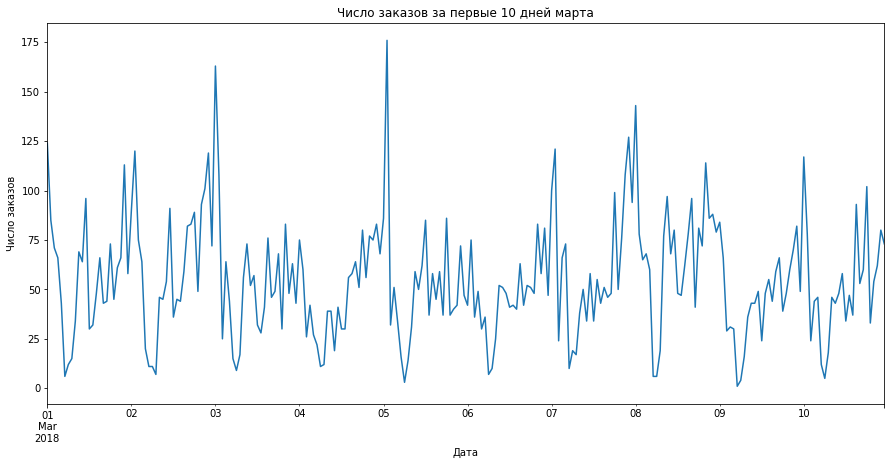

In [ ]:
df["2018-03-01":"2018-03-10"].plot(
    figsize=(15, 7),
    xlabel="Дата",
    ylabel="Число заказов",
    title="Число заказов за первые 10 дней марта",
    legend=False,
);

Теперь рассмотрим график скользящего среднего и стандартного отклонения. Интервал выберем 720 - количество часов в тридцатидневном месяце.

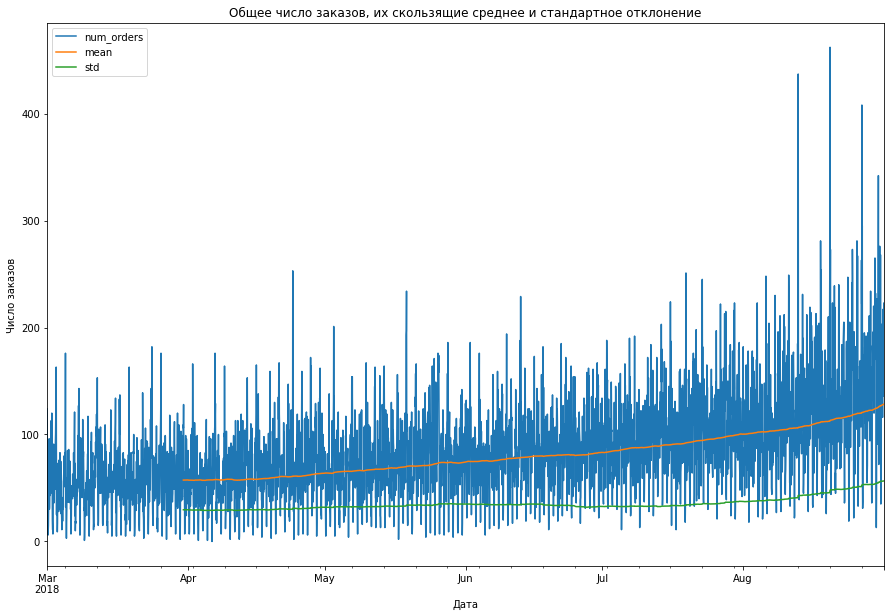

In [ ]:
data = df.copy()
data['mean'] = data['num_orders'].rolling(720).mean()
data['std'] = data['num_orders'].rolling(720).std()
data.plot(
    figsize=(15, 10),
    xlabel="Дата",
    ylabel="Число заказов",
    title="Общее число заказов, их скользящие среднее и стандартное отклонение",
);

По графикам можем сделать вывод о наличиии сезонности и тренда в данных. Подтвердим наш вывод далее.

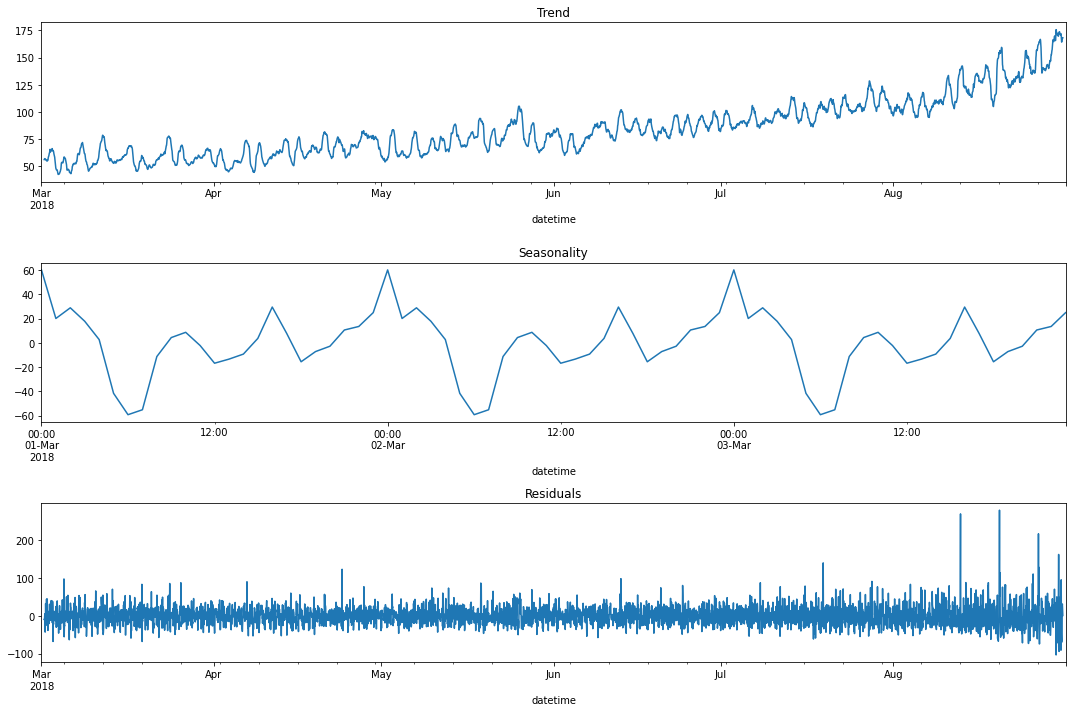

In [ ]:
# для лучшего отображения рассмотрим интервал в один месяц
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На лицо сезонность и тренд, а также имеется доля случайной величины. На графике сезонности можем увидеть, что она суточная, где изо дня в день в 00:00 количество заказов максимально, в 06:00 - минимально.

Далее выполним ресемплинг данных по суткам, после чего выполним его декомпозицию с целью определить наличие недельной сезонности.

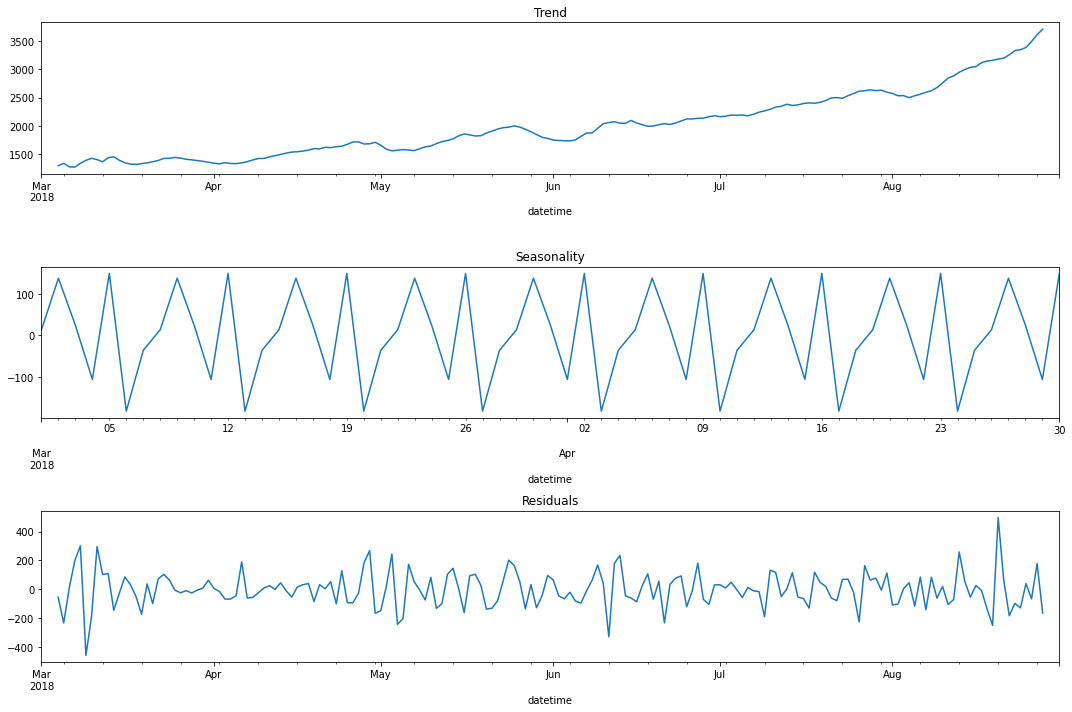

In [ ]:
df_daily = df.resample('1D').sum()
decomposed = seasonal_decompose(df_daily['num_orders'])
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наше предположение подтвердилось, видна недельная сезонность. По понедельникам и пятницам количество заказов максимально, по вторникам и воскресеньям - минимально.

Проверим при помощи теста Дики-Фулера временной ряд на стационарность. В качестве нулевой гипотезы примем - ряд не стационарный, в качестве альтернативной - ряд стационарный.

In [ ]:
def adf(series, alpha=0.05):
    p_value = ts.adfuller(series)[1]
    print(f"p-value = {p_value}")
    if p_value > alpha:
        print('Ряд не стационарный')
    else:
        print('Ряд стационарный')

In [ ]:
adf(df['num_orders'])

p-value = 0.028940051402612906
Ряд стационарный


Тест определил - ряд является стационарным. Но мы видим наличие сезонности и тренда, что является признаками нестационарного ряда.

**Вывод по второму шагу:** Построили графики временного ряда, обнаружили в них тренд и сезонность. Мы определили суточную сезонность, где изо дня в день в 00:00 количество заказов максимально, в 06:00 - минимально. А также выявили недельную сезонность: по понедельникам и пятницам количество заказов максимально, по вторникам и воскресеньям - минимально.

## Обучение

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания признаков.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df, 168, 168)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna()

Отделим обучающие и целевой признаки. Выделим 10% данных для тестирования моделей, остальные используем для обучения.

In [ ]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1
)

Рассмотрим три модели, подберем гиперпараметры при помощи `GridSearchCV`. Результаты их работы соберем в одну табличку.

### DecisionTree

In [ ]:
scores = []

In [ ]:
tree = DecisionTreeRegressor(random_state=99)

In [ ]:
tree_params = {'max_depth': range(6, 15)}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
gsc_tree = GridSearchCV(tree, tree_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)

In [ ]:
gsc_tree.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': range(6, 15)},
             scoring='neg_root_mean_squared_error')

In [ ]:
gsc_tree.best_params_

{'max_depth': 6}

In [ ]:
scores.append(-gsc_tree.best_score_)

### RandomForest

In [ ]:
forest = RandomForestRegressor(random_state=99)

In [ ]:
forest_params =({'max_depth':range(10, 13),
            'n_estimators':range(100, 200, 50),
             })

In [ ]:
gsc_forest = GridSearchCV(forest, forest_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)

In [ ]:
gsc_forest.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': range(10, 13),
                         'n_estimators': range(100, 200, 50)},
             scoring='neg_root_mean_squared_error')

In [ ]:
gsc_forest.best_params_

{'max_depth': 12, 'n_estimators': 150}

In [ ]:
scores.append(-gsc_forest.best_score_)

### LinearRegression

Выполним масштабирование признаков.

In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

In [ ]:
res_num = num_pipeline.fit_transform(features_train)
res_num_test = num_pipeline.transform(features_test)

In [ ]:
features_train_scaled = pd.DataFrame(res_num,
                        columns=features_train.columns)
features_test_scaled = pd.DataFrame(res_num_test,
                        columns=features_test.columns)
features_train_scaled.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
0,-0.007568,-1.658183,0.371383,1.220297,0.731578,-0.091694,-0.761460,0.503408,-0.813284,-0.864493,...,-1.152519,-1.661747,-1.741062,-1.900674,-0.907788,-0.290613,-0.156171,0.219401,1.265053,-1.389056
1,-0.007568,-1.513798,1.632878,0.370807,1.220794,0.733120,-0.091302,-0.762066,0.504134,-0.812821,...,-0.212598,-1.151689,-1.660554,-1.739712,-1.900278,-0.907588,-0.290319,-0.156212,0.218816,-1.382467
2,-0.007568,-1.369413,-0.040533,1.632171,0.371103,1.222854,0.733507,-0.090590,-0.761621,0.504811,...,-0.346872,-0.212107,-1.150672,-1.659232,-1.739334,-1.900114,-0.907400,-0.290359,-0.156756,-1.384895
3,-0.007568,-1.225027,-0.375215,-0.041068,1.632765,0.372264,1.223238,0.735842,-0.089996,-0.761149,...,0.512483,-0.346333,-0.211416,-1.149521,-1.658862,-1.739163,-1.900097,-0.907437,-0.290889,-1.386975
4,-0.007568,-1.080642,-0.297981,-0.375715,-0.040868,1.635261,0.372653,1.226535,0.736620,-0.089415,...,-1.259938,0.512713,-0.345595,-0.210580,-1.149204,-1.658688,-1.739119,-1.900128,-0.907901,-1.386282


Обучим и проверим модель.

In [ ]:
linear = LinearRegression()

In [ ]:
linear_params =({'fit_intercept':[True, False],
            'copy_X':[True, False],
             })

In [ ]:
gsc_linear = GridSearchCV(linear, linear_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)

In [ ]:
gsc_linear.fit(features_train_scaled, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error')

In [ ]:
gsc_linear.best_params_

{'copy_X': True, 'fit_intercept': True}

In [ ]:
scores.append(-gsc_linear.best_score_)

### Сравнение моделей

In [ ]:
pd.DataFrame(scores, columns=['RMSE'], index=['DecisionTree', 'RandomForest', 'LinearRegression'])

,RMSE
DecisionTree,29.400710
RandomForest,23.094246
LinearRegression,22.704620


**Вывод по третьему шагу:** лучше всего себя показала модель линейной регрессии, далее перейдем к её тестированию.

## Тестирование

Проверим лучшую модель на тестовой выборке.

In [ ]:
best_model = gsc_linear.best_estimator_

In [ ]:
predictions = best_model.predict(features_test_scaled)

In [ ]:
rmse = mean_squared_error(target_test, predictions) ** 0.5
rmse

34.25980525349294

Зададим константное предсказание медианой, измерим метрику для неё, для сравнения и проверки лучшей модели на адекватность.

In [ ]:
pred_median = np.ones(target_test.shape) * target_train.median()
rmse = mean_squared_error(target_test, pred_median) ** 0.5
rmse

87.03915278566916

**Вывод по четвертому шагу:** проверили лучшую модель на тестовой выборке, получили значение метрики RMSE равное 34,26. Для проверки на адекватность задали константный прогноз, в этом случае метрика ухудшилась более чем в два раза, из чего можно сделать вывод, что наша модель адекватна.

## Общий вывод

Загрузили таблицу с данными, при чтении преобразовав тип данных даты и времени в `datetime64` для правильной обработки времени, и преобразовав данный столбец в индексы для удобства работы с ним.

Получили датафрейм из одного столбца типа `int64` и 2496-ти строк.

После чего выполнили ресемплирование данных по одному часу, где для каждого часа отражается общее количество заказов в этот час. В результате количество строк таблицы данных уменьшилось до 4416-ти.

Построили графики временного ряда, обнаружили в них тренд и сезонность. Мы определили суточную сезонность, где изо дня в день в 00:00 количество заказов максимально, в 06:00 - минимально. А также выявили недельную сезонность: по понедельникам и пятницам количество заказов максимально, по вторникам и воскресеньям - минимально.

После чего рассмотрели три модели: `DecisionTreeRegressor`, `RandomForestRegressor`, `LinearRegression`,  подобрали гиперпараметры при помощи `GridSearchCV`. Лучше всего себя показала модель линейной регрессии.

Проверили лучшую модель на тестовой выборке, получили значение метрики RMSE равное 34,26. Для проверки на адекватность задали константный прогноз, в этом случае метрика ухудшилась более чем в два раза, из чего можно сделать вывод, что наша модель адекватна.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48